In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Exploration

In [18]:
test = torch.load("/home/max/Studium/Leipzig/Semster6/Math_and_ML/math-ml/output.pt")

In [19]:
print(test.keys())
print(len(test.keys()))

dict_keys(['prompt0', 'prompt1', 'prompt2', 'prompt3', 'prompt4', 'prompt5', 'prompt6', 'prompt7', 'prompt8', 'prompt9', 'prompt10', 'prompt11', 'prompt12', 'prompt13', 'prompt14', 'prompt15', 'prompt16', 'prompt17', 'prompt18', 'prompt19', 'prompt20', 'prompt21', 'prompt22', 'prompt23', 'prompt24', 'prompt25', 'prompt26', 'prompt27', 'prompt28', 'prompt29', 'prompt30', 'prompt31', 'prompt32', 'prompt33', 'prompt34', 'prompt35', 'prompt36', 'prompt37', 'prompt38', 'prompt39', 'prompt40', 'prompt41', 'prompt42', 'prompt43', 'prompt44', 'prompt45', 'prompt46', 'prompt47', 'prompt48', 'prompt49', 'prompt50', 'prompt51', 'prompt52', 'prompt53', 'prompt54', 'prompt55', 'prompt56', 'prompt57', 'prompt58', 'prompt59', 'prompt60', 'prompt61', 'prompt62', 'prompt63', 'prompt64', 'prompt65', 'prompt66', 'prompt67', 'prompt68', 'prompt69', 'prompt70', 'prompt71', 'prompt72', 'prompt73', 'prompt74', 'prompt75', 'prompt76', 'prompt77', 'prompt78', 'prompt79', 'prompt80', 'prompt81', 'prompt82', 'pr

In [20]:
test['prompt0'].keys()

dict_keys(['top_p_tokens', 'top_p_probs', 'top_p_logits', 'generated_tokens', 'entropies', 'cosines', 'prompt'])

In [37]:
print(len(test['prompt0']['entropies']))

200


In [35]:
print(test['prompt0']['top_p_tokens'][0])
print(len(test['prompt0']['top_p_tokens']))
print(test['prompt0']['top_p_logits'][0])
print(test['prompt0']['top_p_probs'][0])
print(test['prompt0']['generated_tokens'][0])
print(len(test['prompt0']['generated_tokens']))
print(test['prompt0']['cosines'][0])
print(test['prompt0']['entropies'][0])
print(test['prompt0']['prompt'][0])

tensor([151667])
200
tensor([36.7500], dtype=torch.bfloat16)
tensor([1.], dtype=torch.bfloat16)
tensor(151667)
200
1
-0.0
<|im_start|>user
 You are a math expert. Solve the question which is below delimited by tripple quotes.
        Put your final answer within braces.
        Question: """Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?"""
        <|im_end|>
<|im_start|>assistant



# Plotting

(200,)
0.01552734375


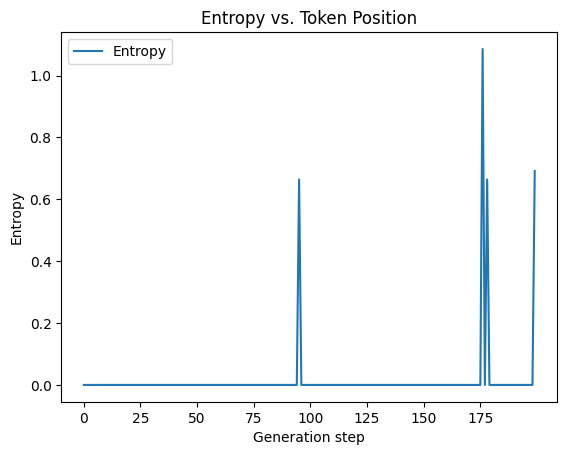

In [ ]:
#entropy over tokens for one prompt
entropies_prompt0 = np.array(test['prompt0']['entropies'])
print(entropies_prompt0.shape)
mean_ent_prompt0 = np.mean(entropies_prompt0, axis=0)
print(mean_ent_prompt0)
plt.plot(entropies_prompt0, label='Entropy')
plt.xticks(np.arange(0, len(entropies_prompt0), 25))
plt.xlabel('Generation step')
plt.ylabel('Entropy')
plt.title('Entropy vs. Token Position')
plt.legend()
plt.show()

(200,)
0.9813232421875


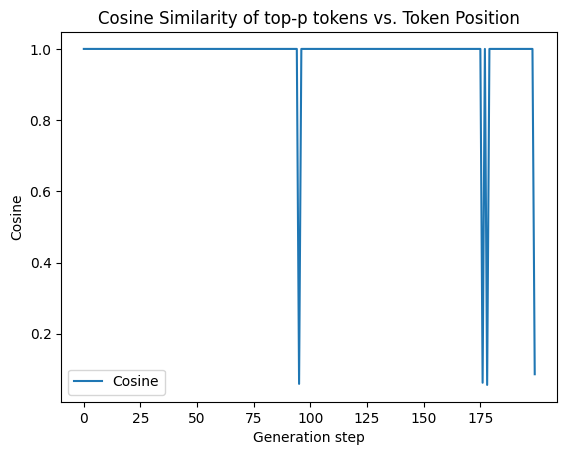

In [ ]:
#cosine over tokens for one prompt
cosines_prompt0 = np.array(test['prompt0']['cosines'])
print(cosines_prompt0.shape)
mean_cos_prompt0 = np.mean(cosines_prompt0, axis=0)
print(mean_cos_prompt0)
plt.plot(cosines_prompt0, label='Cosine')
plt.xticks(np.arange(0, len(entropies_prompt0), 25))
plt.xlabel('Generation step')
plt.ylabel('Cosine')
plt.title('Cosine Similarity of top-p tokens vs. Token Position')
plt.legend()
plt.show()

(100, 200)


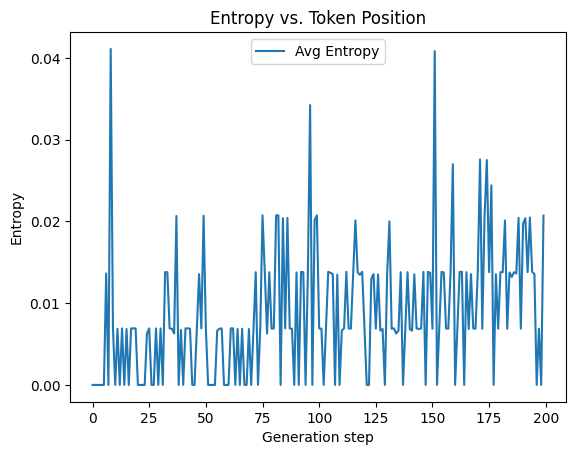

In [ ]:
#avg entropy over all prompts
all_entropies = np.array([res['entropies'] for res in test.values()])  # shape (num_prompts, max_steps)
print(all_entropies.shape)
mean_ent = np.mean(all_entropies, axis=0)
plt.plot(mean_ent, label='Avg Entropy')
plt.xlabel('Generation step')
plt.ylabel('Entropy')
plt.title('Entropy vs. Token Position')
plt.legend()
plt.show()

(100, 200)


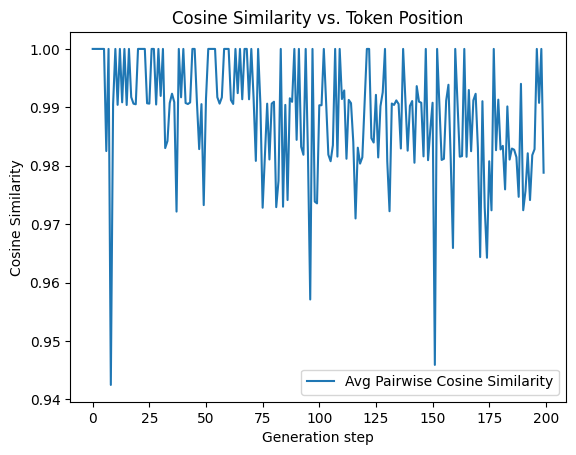

In [ ]:
#avg cosine over all prompts
all_cosines = np.array([res['cosines'] for res in test.values()])  # shape (num_prompts, max_steps)
print(all_cosines.shape)
mean_cos = np.mean(all_cosines, axis=0)
plt.plot(mean_cos, label='Avg Pairwise Cosine Similarity')
plt.xlabel('Generation step')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity vs. Token Position')
plt.legend()
plt.show()

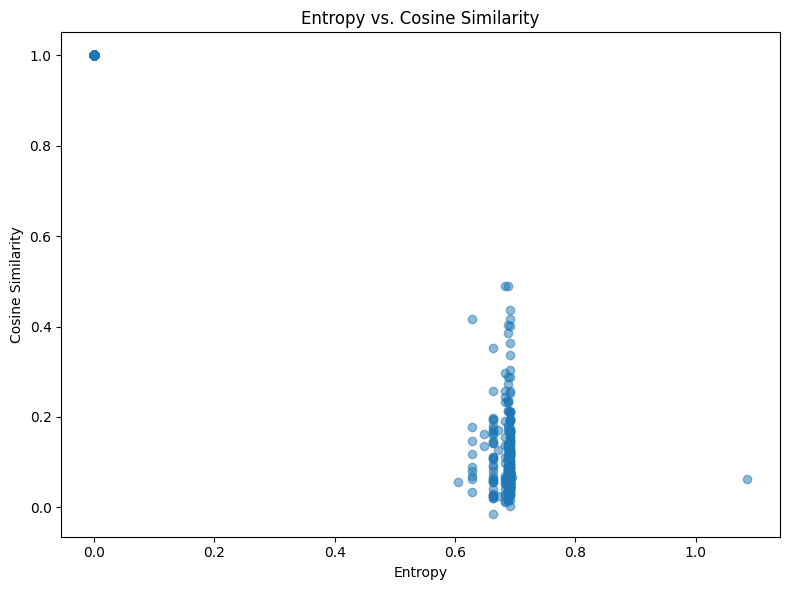

In [ ]:
#Entropy vs cosine similarity at token step
entropies = []
cosines = []
for res in test.values():
    entropies.extend(res['entropies'])
    cosines.extend(res['cosines'])

entropies = np.array(entropies, dtype=float)
cosines = np.array(cosines, dtype=float)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(entropies, cosines, alpha=0.5)
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity')
plt.tight_layout()
plt.show()

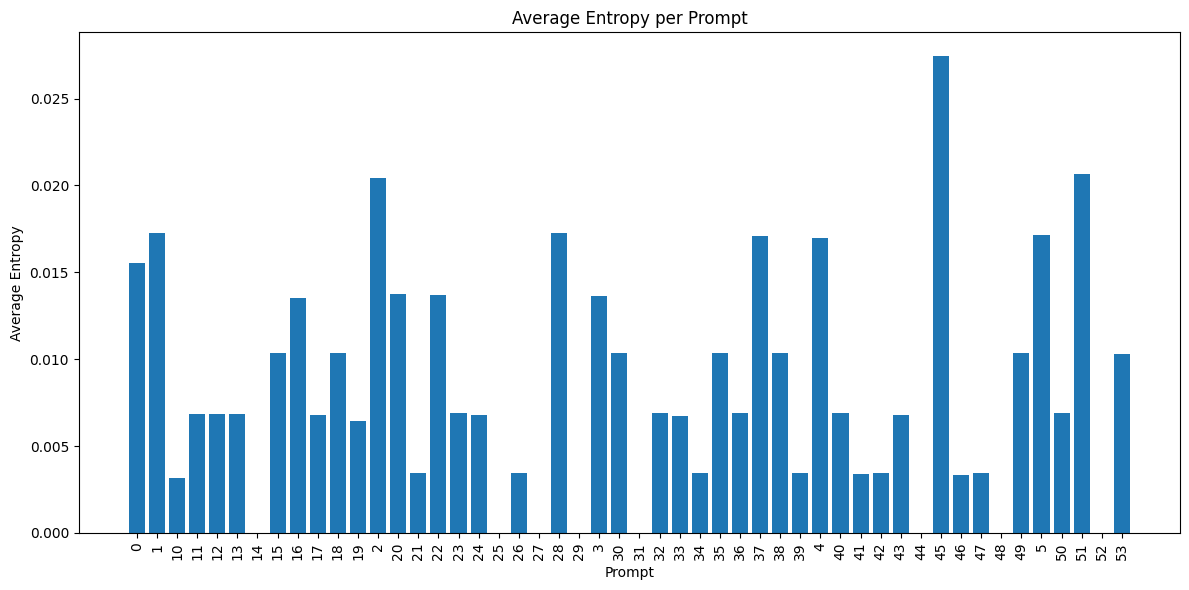

In [ ]:
#maybe uselful for comparing reasoning vs no reasoning (show a small slice of prompts e.g. 50)
slice = 50
prompt_keys = sorted(test.keys())
prompt_keys = prompt_keys[:slice]
avg_entropies = [np.mean(test[k]['entropies']) for k in prompt_keys]
prompt_keys = [key.replace('prompt', '') for key in prompt_keys]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(prompt_keys, avg_entropies)
plt.xlabel('Prompt')
plt.ylabel('Average Entropy')
plt.title('Average Entropy per Prompt')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()